In [7]:
# import libraries
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import IsolationForest
from sklearn.manifold import TSNE
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from collections import Counter

In [8]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PAVANI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PAVANI\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\PAVANI\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [9]:
#load the dataset
file_path = r'C:\Users\PAVANI\OneDrive\Desktop\IBM Project\dataset\health prescription data.csv'
data = pd.read_csv(file_path)


In [10]:
# Text Preprocessing
def preprocess_text(text):
    if pd.isnull(text):
        return ""
    # Remove patterns like [**...**]
    text = re.sub(r'\[\*\*.*?\*\*\]', '', text)
    # Remove metadata like "Admission Date:"
    text = re.sub(r'Admission Date:.*', '', text)
    # Tokenization
    tokens = re.findall(r'\b\w+\b', text.lower())
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)


In [11]:
# Preprocess structured fields
def preprocess_structured_fields(row):
    # Combine Chief Complaint and History of Present Illness
    chief_complaint = preprocess_text(row.get('Chief Complaint', ''))
    history = preprocess_text(row.get('History of Present Illness', ''))
    return f"{chief_complaint} {history}"

In [12]:
import re
import pandas as pd

# Re-extract dates from the 'TEXT' column
data['extracted_date'] = data['TEXT'].apply(lambda x: re.search(r'\d{4}-\d{1,2}-\d{1,2}', x).group(0) if re.search(r'\d{4}-\d{1,2}-\d{1,2}', x) else None)

# Convert to datetime
data['extracted_date'] = pd.to_datetime(data['extracted_date'])
# Normalize all dates to the year 2000
data['normalized_date'] = data['extracted_date'].apply(lambda x: x.replace(year=2000) if pd.notnull(x) else x)
print(data[['extracted_date', 'normalized_date']].head())


  extracted_date normalized_date
0     2162-03-03      2000-03-03
1     2150-02-25      2000-02-25
2     2101-10-25      2000-10-25
3     2148-02-03      2000-02-03
4     2174-05-29      2000-05-29


In [13]:
# Apply preprocessing to the entire dataset
data['combined_text'] = data.apply(preprocess_structured_fields, axis=1)

In [14]:
import pandas as pd
import re
data = pd.read_csv(r"C:\Users\PAVANI\OneDrive\Desktop\IBM Project\dataset\health prescription data.csv")


print(data.columns)  # Check all available columns in the dataset
print(data[['TEXT', 'DIAGNOSIS']].head())  # Check the key columns used for 'combined_text'

# Fill missing values in key columns
data['TEXT'] = data['TEXT'].fillna('')
data['DIAGNOSIS'] = data['DIAGNOSIS'].fillna('')

# Combine columns to create combined_text
data['combined_text'] = data['TEXT'] + ' ' + data['DIAGNOSIS']

# Preprocess text (ensure it doesn't over-clean)
def preprocess_text(text):
    # Remove patterns like [**...**]
    text = re.sub(r'\[\*\*.*?\*\*\]', '', text)
    # Remove metadata like "Admission Date:"
    text = re.sub(r'Admission Date:.*', '', text)
    # Tokenization and cleanup
    tokens = re.findall(r'\b\w+\b', text.lower())
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Apply preprocessing
data['processed_text'] = data['combined_text'].apply(preprocess_text)

Index(['SUBJECT_ID', 'ROW_ID', 'HADM_ID', 'CATEGORY', 'ADMISSION_TYPE',
       'DIAGNOSIS', 'TEXT'],
      dtype='object')
                                                TEXT  \
0  Admission Date:  [**2162-3-3**]              D...   
1  Admission Date:  [**2150-2-25**]              ...   
2  Admission Date:  [**2101-10-25**]             ...   
3  Admission Date:  [**2148-2-3**]              D...   
4  Admission Date:  [**2174-5-29**]              ...   

                                       DIAGNOSIS  
0                             S/P FALL;TELEMETRY  
1                   LEFT SPHENOID MENENGIOMA/SDA  
2                         TYLENOL BENZO OVERDOSE  
3                              PEDISTRIAN STRUCK  
4   RESPIRATORY FAILURE;CONGESTIVE HEART FAILURE  


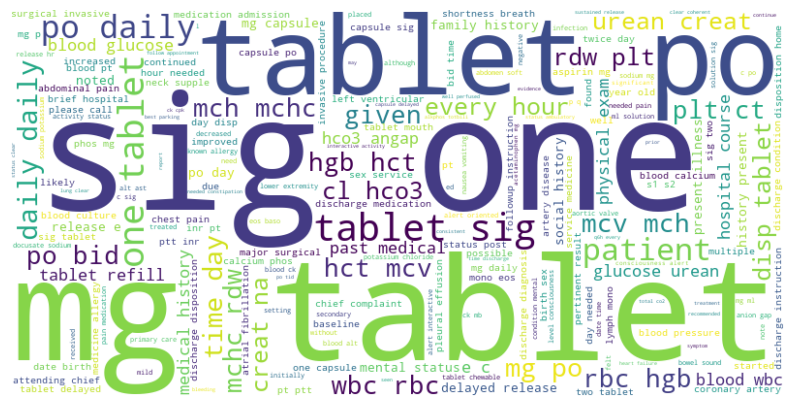

In [15]:
# Generate the word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word cloud
if data['processed_text'].str.strip().str.len().sum() > 0:  # Ensure text is not empty
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(data['processed_text']))
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
else:
    print("No valid text available to generate the word cloud.")

C:\Users\PAVANI\AppData\Local\Temp\ipykernel_19996\2714981583.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette="viridis")


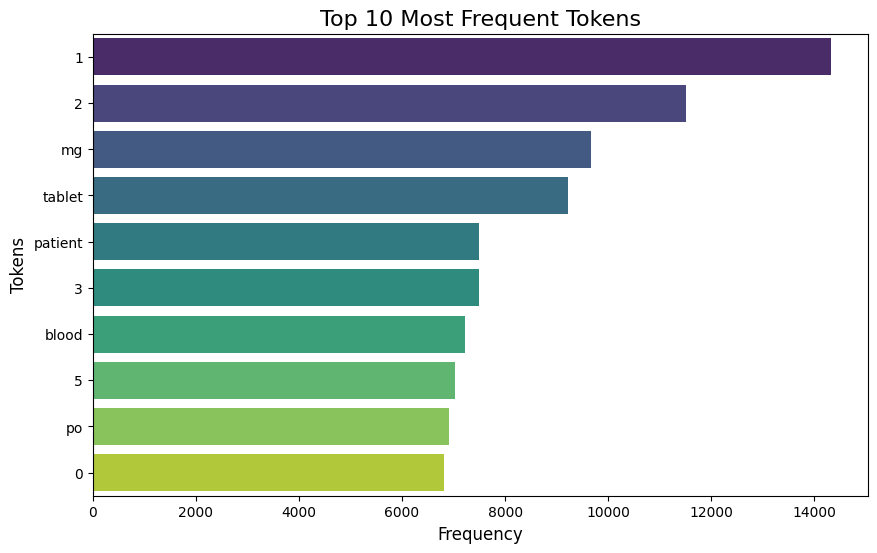

In [16]:
#Text Token Frequency Visualization
from collections import Counter
import seaborn as sns

# Token frequency
all_tokens = ' '.join(data['processed_text']).split()
token_counts = Counter(all_tokens).most_common(10)
words, counts = zip(*token_counts)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=counts, y=words, palette="viridis")
plt.title("Top 10 Most Frequent Tokens", fontsize=16)
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("Tokens", fontsize=12)
plt.show()


In [17]:
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
text_matrix = vectorizer.fit_transform(data['combined_text'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(text_matrix)


LatentDirichletAllocation(n_components=5, random_state=42)

In [18]:
# Extract topics
def display_topics(model, feature_names, num_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
        topics.append(f"Topic {topic_idx + 1}: {', '.join(top_words)}")
    return topics

num_top_words = 10
feature_names = vectorizer.get_feature_names_out()
topics = display_topics(lda, feature_names, num_top_words)

In [19]:
# Output topics
print("Topics from LDA:")
for topic in topics:
    print(topic)


Topics from LDA:
Topic 1: mg, patient, left, day, artery, tablet, aortic, 10, discharge, coronary
Topic 2: patient, right, left, discharge, history, 10, mg, admission, date, ct
Topic 3: blood, pt, 10, right, 12, patient, pulmonary, 11, left, pneumonia
Topic 4: tablet, mg, po, sig, daily, day, pain, discharge, capsule, 10
Topic 5: blood, mg, tablet, po, daily, discharge, 12, 10, 11, pt


C:\Users\PAVANI\AppData\Local\Temp\ipykernel_19996\2788982283.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_scores, y=top_words, palette='viridis')


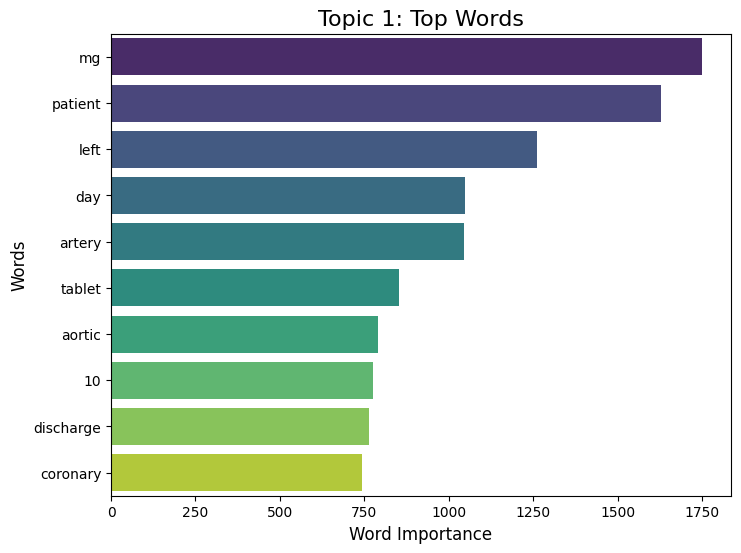

C:\Users\PAVANI\AppData\Local\Temp\ipykernel_19996\2788982283.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_scores, y=top_words, palette='viridis')


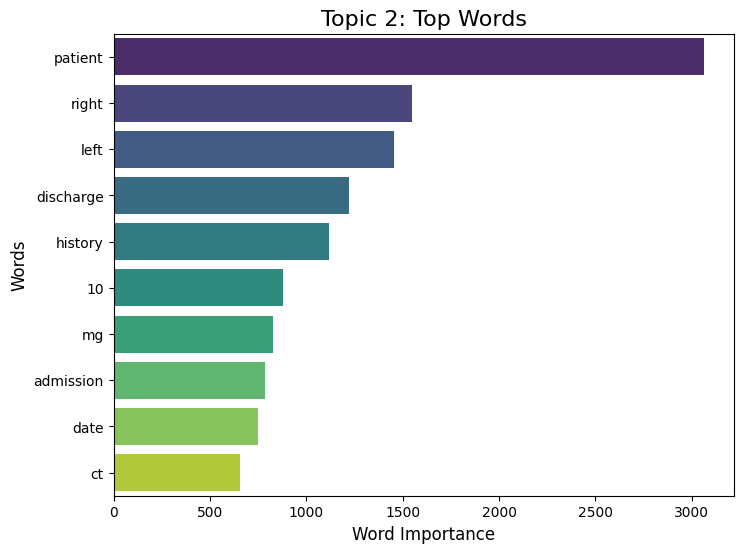

C:\Users\PAVANI\AppData\Local\Temp\ipykernel_19996\2788982283.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_scores, y=top_words, palette='viridis')


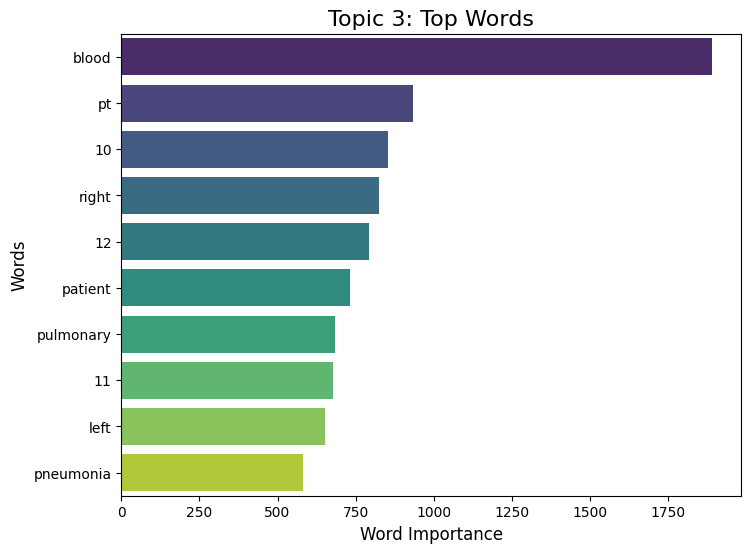

C:\Users\PAVANI\AppData\Local\Temp\ipykernel_19996\2788982283.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_scores, y=top_words, palette='viridis')


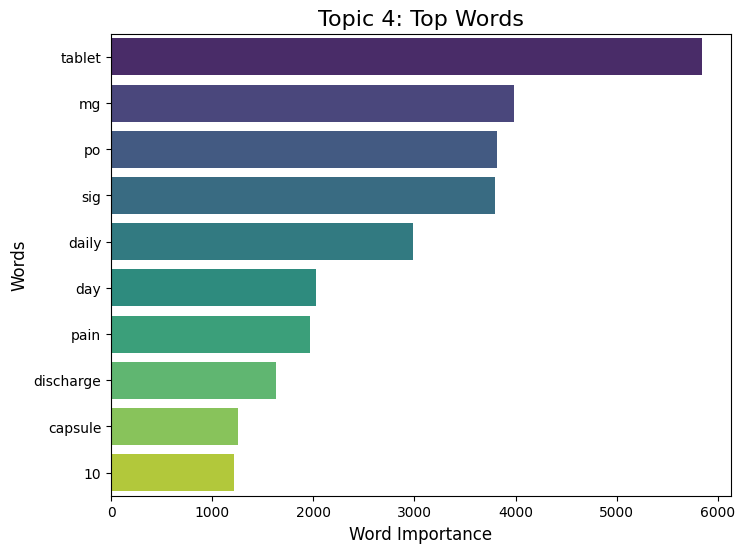

C:\Users\PAVANI\AppData\Local\Temp\ipykernel_19996\2788982283.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_scores, y=top_words, palette='viridis')


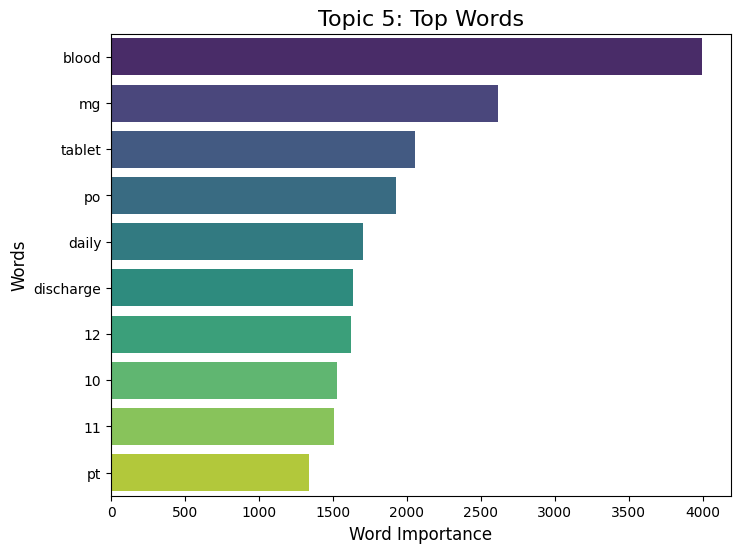

In [20]:
# Visualize topic-word distributions
for topic_idx, topic in enumerate(lda.components_):
    plt.figure(figsize=(8, 6))
    top_words_indices = topic.argsort()[:-11:-1]
    top_words = [feature_names[i] for i in top_words_indices]
    top_scores = topic[top_words_indices]
    sns.barplot(x=top_scores, y=top_words, palette='viridis')
    plt.title(f"Topic {topic_idx + 1}: Top Words", fontsize=16)
    plt.xlabel("Word Importance", fontsize=12)
    plt.ylabel("Words", fontsize=12)
    plt.show()

In [21]:
from sklearn.ensemble import IsolationForest

# Convert cleaned text to numerical features using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
feature_vectors = tfidf_vectorizer.fit_transform(data['processed_text'])

# Apply Isolation Forest
model = IsolationForest(contamination=0.05, random_state=42)
anomalies = model.fit_predict(feature_vectors)

# Add anomaly results to the DataFrame (1 for normal, -1 for anomaly)
data['anomaly'] = anomalies

In [22]:
# Text Embedding Visualization with t-SNE
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
feature_vectors = tfidf_vectorizer.fit_transform(data['combined_text'])

# Reduce dimensions using t-SNE
tsne_model = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_result = tsne_model.fit_transform(feature_vectors.toarray())

c:\Users\PAVANI\OneDrive\Desktop\IBM Project\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


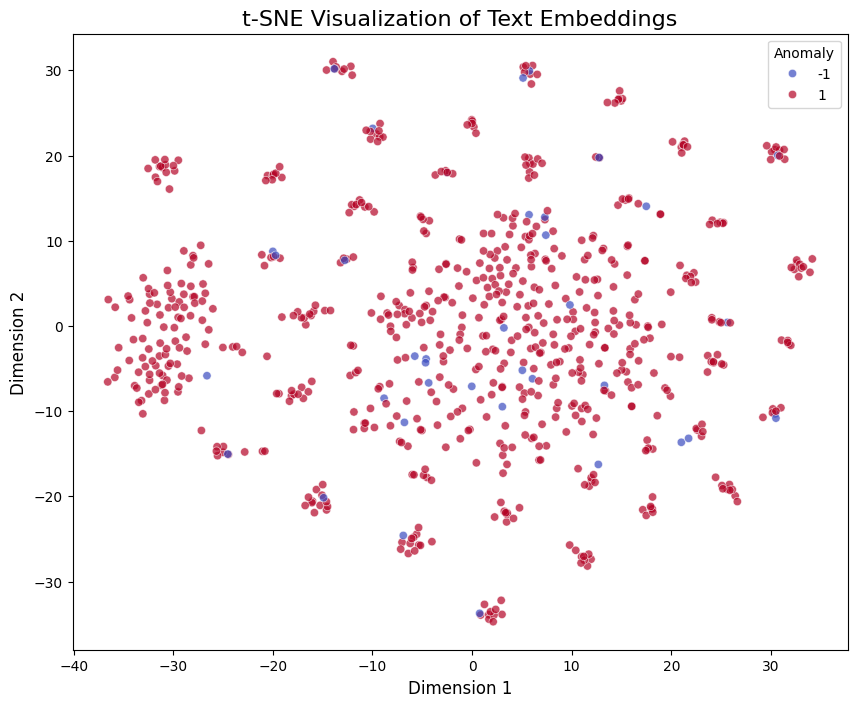

In [23]:
# Plot t-SNE visualization
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=data['anomaly'], palette="coolwarm", alpha=0.7)
plt.title("t-SNE Visualization of Text Embeddings", fontsize=16)
plt.xlabel("Dimension 1", fontsize=12)
plt.ylabel("Dimension 2", fontsize=12)
plt.legend(title="Anomaly", loc='best')
plt.show()

In [24]:
print(data['processed_text'].head(10))


0    date birth sex service medicine allergy patien...
1    date birth sex service neurosurgery allergy kn...
2    date birth sex f service medicine allergy ceph...
3    date birth sex f service surgery allergy known...
4    date birth sex f service medicine allergy ator...
5    service medicine history present illness patie...
6    date birth sex service surgery allergy percoce...
7    date birth sex f service medicine allergy lomo...
8    date birth sex service medicine allergy known ...
9    service medicine allergy demerol shellfish der...
Name: processed_text, dtype: object


In [25]:
print(data['processed_text'].isnull().sum())  # Check for missing values
print((data['processed_text'] == '').sum())   # Check for empty strings


0
0


In [26]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
sample_text = ' '.join(data['processed_text'].head(10))
print([word for word in sample_text.split() if word in stop_words])


['m', 'm']


In [27]:
print(re.findall(r'[^a-z\s]', ' '.join(data['processed_text']), flags=re.I))


['1', '0', '6', '7', '1', '6', '7', '2', '3', '4', '5', '6', '7', '5', '5', '6', '7', '6', '6', '7', '1', '7', '4', '1', '8', '4', '1', '9', '8', '2', '1', '0', '9', '7', '5', '6', '1', '1', '4', '5', '6', '7', '2', '2', '2', '9', '8', '9', '8', '9', '1', '4', '2', '7', '0', '6', '1', '2', '0', '9', '6', '2', '2', '0', '7', '7', '0', '1', '2', '1', '8', '8', '4', '4', '4', '3', '1', '1', '9', '3', '8', '6', '8', '7', '2', '6', '9', '3', '0', '9', '1', '7', '3', '1', '9', '1', '2', '0', '4', '2', '8', '1', '1', '9', '1', '8', '3', '7', '0', '8', '5', '2', '0', '1', '9', '1', '2', '1', '2', '3', '1', '4', '0', '4', '3', '1', '0', '1', '3', '2', '6', '1', '6', '6', '7', '6', '7', '6', '2', '1', '2', '3', '1', '2', '3', '4', '5', '1', '2', '3', '1', '1', '2', '3', '4', '1', '5', '1', '2', '3', '4', '1', '2', '2', '0', '4', '9', '2', '1', '2', '5', '1', '0', '5', '9', '1', '2', '2', '5', '3', '3', '5', '4', '5', '6', '1', '1', '3', '0', '1', '0', '6', '7', '6', '7', '6', '7', '1', '4', '1',

In [28]:
from collections import Counter

all_tokens = ' '.join(data['processed_text']).split()
token_counts = Counter(all_tokens).most_common(10)
print(token_counts)


[('1', 14326), ('2', 11513), ('mg', 9675), ('tablet', 9222), ('patient', 7502), ('3', 7488), ('blood', 7226), ('5', 7034), ('po', 6902), ('0', 6810)]


In [29]:
for i in range(5):  # Compare the first 5 rows
    print(f"--- Row {i + 1} ---")
    print(f"Original Text:\n{data['TEXT'].iloc[i]}\n")
    print(f"Processed Text:\n{data['processed_text'].iloc[i]}\n")
    print("-" * 50)  # Separator for better readability


--- Row 1 ---
Original Text:
Admission Date:  [**2162-3-3**]              Discharge Date:   [**2162-3-25**]

Date of Birth:  [**2080-1-4**]             Sex:   M

Service: MEDICINE

Allergies:
Patient recorded as having No Known Allergies to Drugs

Attending:[**First Name3 (LF) 1828**]
Chief Complaint:
Mr. [**Known lastname 1829**] was seen at [**Hospital1 18**] after a mechanical fall from
a height of 10 feet.  CT scan noted unstable fracture of C6-7 &
posterior elements.

Major Surgical or Invasive Procedure:
1. Anterior cervical osteotomy, C6-C7, with decompression and
excision of ossification of the posterior longitudinal ligament.
2. Anterior cervical deformity correction.
3. Interbody reconstruction.
4. Anterior cervical fusion, C5-C6-C7.
5. Plate instrumentation, C5-C6-C7.
6. Cervical laminectomy C6-C7, T1.
7. Posterior cervical arthrodesis C4-T1.
8. Cervical instrumentation C4-T1.
9. Arthrodesis augmentation with autograft, allograft and
demineralized bone matrix.


History of P

In [30]:
comparison_df = data[['TEXT', 'processed_text']].head(10)
comparison_df.to_csv('text_comparison.csv', index=False)
print("Comparison saved to 'text_comparison.csv'.")


Comparison saved to 'text_comparison.csv'.


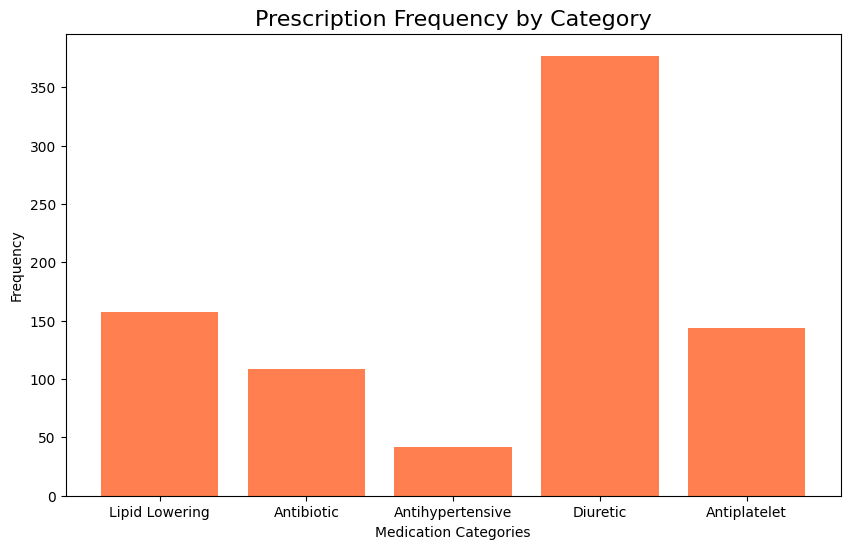

In [31]:
# Example mapping of medications to categories
from collections import Counter
import matplotlib.pyplot as plt
med_categories = {
    "atorvastatin": "Lipid Lowering",
    "ceftriaxone": "Antibiotic",
    "losartan": "Antihypertensive",
    "lasix": "Diuretic",
    "plavix": "Antiplatelet"
}
data['Category'] = data['TEXT'].apply(lambda x: [med_categories.get(word.lower(), "Other") for word in x.split() if word.lower() in med_categories])

# Flatten and count categories
all_categories = [cat for sublist in data['Category'] for cat in sublist]
category_count = Counter(all_categories)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(category_count.keys(), category_count.values(), color='coral')
plt.title("Prescription Frequency by Category", fontsize=16)
plt.xlabel("Medication Categories")
plt.ylabel("Frequency")
plt.show()


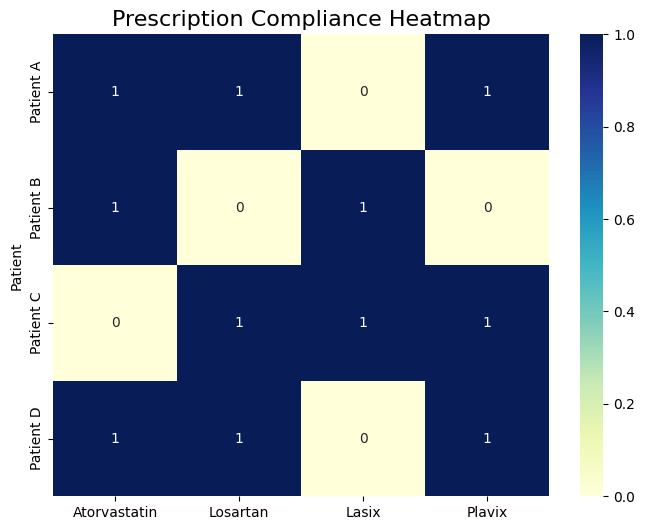

In [32]:
import seaborn as sns

# Example compliance data (true/false for guideline adherence)
compliance_data = {
    "Patient": ["Patient A", "Patient B", "Patient C", "Patient D"],
    "Atorvastatin": [1, 1, 0, 1],
    "Losartan": [1, 0, 1, 1],
    "Lasix": [0, 1, 1, 0],
    "Plavix": [1, 0, 1, 1]
}

compliance_df = pd.DataFrame(compliance_data).set_index("Patient")

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(compliance_df, annot=True, cmap="YlGnBu", cbar=True)
plt.title("Prescription Compliance Heatmap", fontsize=16)
plt.show()


        text_length  diagnosis_length
count    744.000000        744.000000
mean   10805.412634         21.713710
std     5084.024589         11.797074
min      701.000000          4.000000
25%     7156.000000         12.000000
50%    10220.000000         20.000000
75%    13518.000000         27.000000
max    32759.000000         50.000000


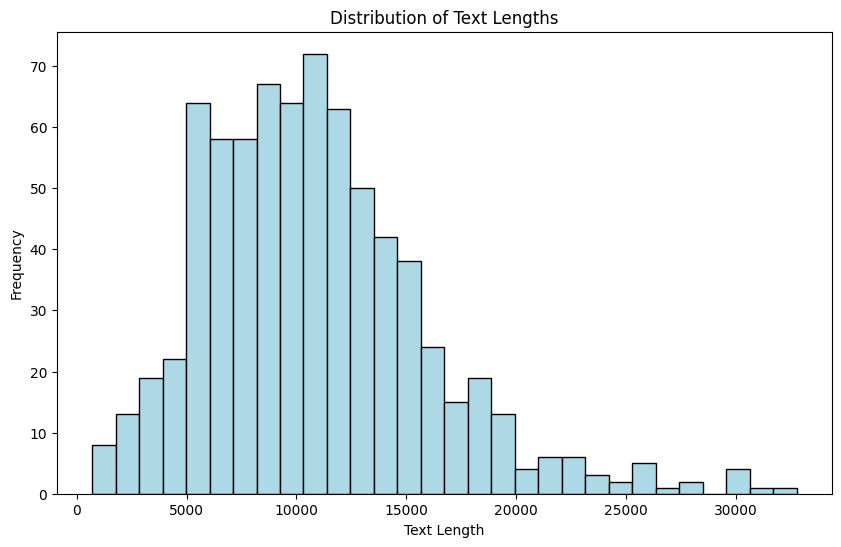

In [33]:
# Add columns for text length
#load the dataset
import pandas as pd
import matplotlib.pyplot as plt
file_path = r'C:\Users\PAVANI\OneDrive\Desktop\IBM Project\dataset\health prescription data.csv'
data = pd.read_csv(file_path)
data['text_length'] = data['TEXT'].apply(len)
data['diagnosis_length'] = data['DIAGNOSIS'].apply(len)
# Summary statistics for text lengths
print(data[['text_length', 'diagnosis_length']].describe())

# Histogram of text lengths
plt.figure(figsize=(10, 6))
plt.hist(data['text_length'], bins=30, color='lightblue', edgecolor='black')
plt.title("Distribution of Text Lengths")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()



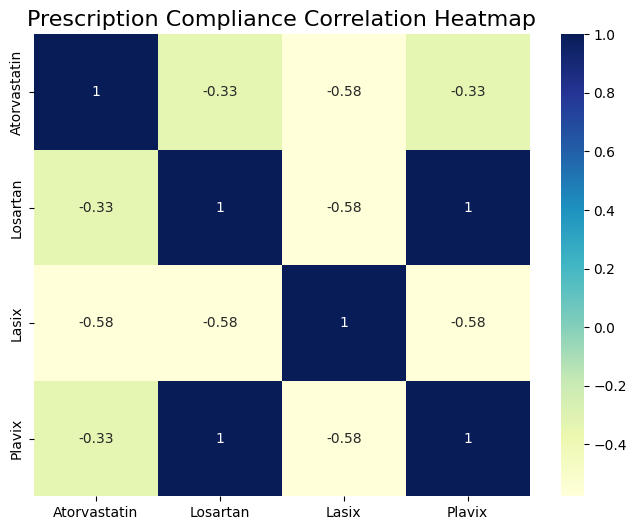

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example compliance data (true/false for guideline adherence)
compliance_data = {
    "Patient": ["Patient A", "Patient B", "Patient C", "Patient D"],
    "Atorvastatin": [1, 1, 0, 1],
    "Losartan": [1, 0, 1, 1],
    "Lasix": [0, 1, 1, 0],
    "Plavix": [1, 0, 1, 1]
}

compliance_df = pd.DataFrame(compliance_data).set_index("Patient")

# Calculate correlation matrix
correlation_matrix = compliance_df.corr()

# Plot heatmap of correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu", cbar=True)
plt.title("Prescription Compliance Correlation Heatmap", fontsize=16)
plt.show()


<>:6: SyntaxWarning: invalid escape sequence '\h'
<>:6: SyntaxWarning: invalid escape sequence '\h'
C:\Users\PAVANI\AppData\Local\Temp\ipykernel_19996\3837579274.py:6: SyntaxWarning: invalid escape sequence '\h'
  data = pd.read_csv('dataset\health prescription data.csv')


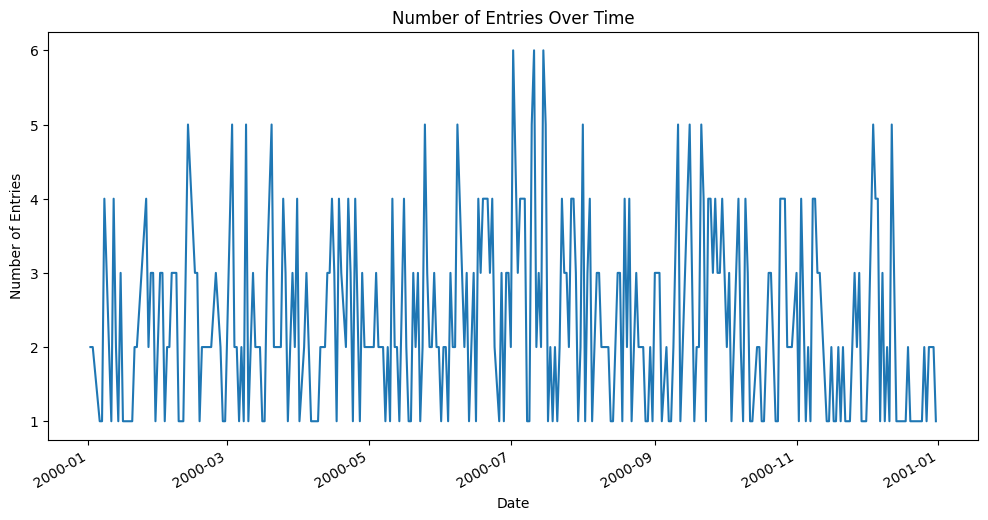

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import re

# Load your data
data = pd.read_csv('dataset\health prescription data.csv')

# Re-extract dates from the 'TEXT' column
data['extracted_date'] = data['TEXT'].apply(lambda x: re.search(r'\d{4}-\d{1,2}-\d{1,2}', x).group(0) if re.search(r'\d{4}-\d{1,2}-\d{1,2}', x) else None)

# Convert to datetime
data['extracted_date'] = pd.to_datetime(data['extracted_date'])
# Normalize all dates to the year 2000
data['normalized_date'] = data['extracted_date'].apply(lambda x: x.replace(year=2000) if pd.notnull(x) else x)


# Plot trends over time
plt.figure(figsize=(12, 6))
data.groupby('normalized_date').size().plot()

plt.title('Number of Entries Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Entries')
plt.show()


In [36]:
import pandas as pd
from sklearn.impute import KNNImputer

# Load dataset
data = pd.read_csv(r"C:\Users\PAVANI\OneDrive\Desktop\IBM Project\dataset\health prescription data.csv")

# Select only numeric columns
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# KNN Imputer
imputer = KNNImputer(n_neighbors=5)
data_cleaned = pd.DataFrame(imputer.fit_transform(numeric_data), columns=numeric_data.columns)

# Replace imputed values back to original dataset (if needed)
data[numeric_data.columns] = data_cleaned

# Display cleaned data
print(data.head())


   SUBJECT_ID  ROW_ID   HADM_ID           CATEGORY ADMISSION_TYPE  \
0     26880.0   178.0  135453.0  Discharge summary      EMERGENCY   
1     42130.0   181.0  114236.0  Discharge summary       ELECTIVE   
2     76874.0   212.0  113329.0  Discharge summary      EMERGENCY   
3     66479.0   220.0  134640.0  Discharge summary      EMERGENCY   
4     31502.0     8.0  125483.0  Discharge summary      EMERGENCY   

                                       DIAGNOSIS  \
0                             S/P FALL;TELEMETRY   
1                   LEFT SPHENOID MENENGIOMA/SDA   
2                         TYLENOL BENZO OVERDOSE   
3                              PEDISTRIAN STRUCK   
4   RESPIRATORY FAILURE;CONGESTIVE HEART FAILURE   

                                                TEXT  
0  Admission Date:  [**2162-3-3**]              D...  
1  Admission Date:  [**2150-2-25**]              ...  
2  Admission Date:  [**2101-10-25**]             ...  
3  Admission Date:  [**2148-2-3**]              D...

In [37]:
print(data.columns)


Index(['SUBJECT_ID', 'ROW_ID', 'HADM_ID', 'CATEGORY', 'ADMISSION_TYPE',
       'DIAGNOSIS', 'TEXT'],
      dtype='object')


In [38]:
import joblib
import pandas as pd

# Load model and vectorizer
model = joblib.load('text_classification_model.pkl')
vectorizer = joblib.load('vectorizer.pkl')

# Test data
test_data = [
    "Patient diagnosed with pneumonia. She has difficulty breathing and coughing.",
    "The patient has heart failure with reduced ejection fraction.",
    "Patient has diabetes. Blood sugar levels are elevated.",
    "The patient is experiencing shortness of breath, typical of asthma."
]

# Transform test data
test_tfidf = vectorizer.transform(test_data)

# Get predictions
predictions = model.predict(test_tfidf)

# Print predictions
print(predictions)


[' PNEUMONIA' ' PNEUMONIA' ' PNEUMONIA' ' PNEUMONIA']


In [39]:
import pandas as pd
# Assuming 'data' is your dataframe
print(data['DIAGNOSIS'].value_counts())


DIAGNOSIS
PNEUMONIA                                            33
SEPSIS                                               26
CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...    20
LOWER GI BLEED                                       17
CONGESTIVE HEART FAILURE                             16
                                                     ..
INCREASING SHORTNESS OF BREATH\RIGHT HEART CAT...     1
RIGHT FRONTAL BLEED                                   1
VENTRAL HERNIA/SDA                                    1
ALLERGIC REACTION                                     1
VISION LOSS                                           1
Name: count, Length: 434, dtype: int64


In [40]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)


NameError: name 'X_train' is not defined